In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import numpy as np
import yaml
import os

seed=456

In [6]:
##  Extracting data
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

model_path = config["model"]["path"]
output_path = config["output"]["path"]

train_df = pd.read_csv(config["data"]["processed_train_path"])
test_df = pd.read_csv(config["data"]["processed_test_path"])

# Define our features (X) and target (y)
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
X_train = train_df[features]
X_test=test_df[features]
y_train = train_df['player_won']
#print(features)

X_train, X_vali, y_train, y_vali = train_test_split(X_train, y_train,train_size=0.8,shuffle=True)



In [ ]:
scaler=StandardScaler()
scaler.fit(X_train)
X_train=scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
variances = X_train.var()
low_variance = variances[variances < 1e-2].index
X_train.drop(columns = low_variance)
X_test.drop(columns = low_variance)



AttributeError: 'numpy.ndarray' object has no attribute 'index'

## Logistic Regression

In [22]:
## GRID SEARCH
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# Scaling all the data


model = LogisticRegression(random_state=seed)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
         ## comment if u change the dataset
    'penalty': ['l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_logreg = grid_search.best_estimator_


Fitting 5 folds for each of 12 candidates, totalling 60 fits


KeyboardInterrupt: 

In [ ]:
## TRAINING IN THE TRAINING SET
logreg=LogisticRegression(**grid_search.best_params_,random_state=seed)
logreg.fit(X_train,y_train)
y_pred= logreg.predict(X_vali)
print("acc",accuracy_score(y_vali,y_pred))
best_logreg=logreg

acc 0.8085


## KNN

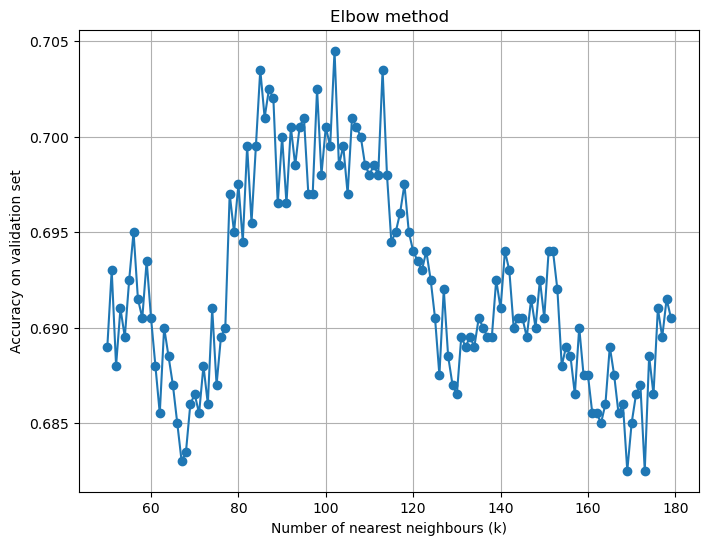

Best k: 102
Accuracy for validation set: 0.7045
Fitting 5 folds for each of 6 candidates, totalling 30 fits
 Best model mean validation accuracy: 0.7134
 Standard deviation across validation folds: 0.0100
Best hyperparameters found: {'metric': 'manhattan', 'n_neighbors': 102, 'weights': 'distance'}
Best accuracy in CV: 0.7134


In [12]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score



model = KNeighborsClassifier()

k_values = list(range(50,180))
accuracies=[]
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_vali)
    acc = accuracy_score(y_vali, y_pred)
    accuracies.append(acc)


plt.figure(figsize=(8,6))
plt.plot(k_values, accuracies, marker='o')
plt.title("Elbow method")
plt.xlabel("Number of nearest neighbours (k)")
plt.ylabel("Accuracy on validation set")
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(accuracies)]
print(f"Best k: {best_k}")
print(f"Accuracy for validation set: {max(accuracies):.4f}")

param_grid = {
    'n_neighbors': [best_k],           
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski','manhattan', 'euclidean'],
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3,
    return_train_score= True
)


grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_knn = grid_search.best_estimator_

In [13]:
### This is the total knn classifier

best_knn = KNeighborsClassifier(**grid_search.best_params_)
best_knn.fit(X_train, y_train)
y_pred= best_knn.predict(X_vali)
print("acc",accuracy_score(y_vali,y_pred))

acc 0.726


# DECISION TREES


In [14]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score


# No need to scale the data

model = DecisionTreeClassifier(random_state=seed)

k_range = list(range(60,200,20))

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'], # impurity function to minimize
    'max_depth': [15], # max_depth of the tree
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=3,
    return_train_score= True
)

grid_search.fit(X_train, y_train)
best_index = grid_search.best_index_
mean_acc = grid_search.cv_results_['mean_test_score'][best_index]
std_acc = grid_search.cv_results_['std_test_score'][best_index]

print(f" Best model mean validation accuracy: {mean_acc:.4f}")
print(f" Standard deviation across validation folds: {std_acc:.4f}")
print("Best hyperparameters found:", grid_search.best_params_)
print(f"Best accuracy in CV: {grid_search.best_score_:.4f}")


best_dt = grid_search.best_estimator_

Fitting 5 folds for each of 3 candidates, totalling 15 fits
 Best model mean validation accuracy: 0.7413
 Standard deviation across validation folds: 0.0055
Best hyperparameters found: {'criterion': 'gini', 'max_depth': 15}
Best accuracy in CV: 0.7413


# RANDOM FOREST

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
# Random Forest
rforest = RandomForestClassifier(
    criterion='gini',
    max_depth=10,
    n_estimators=400,
    random_state=seed
)

# K-Fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Calcolo dell’accuracy media con cross-validation
scores = cross_val_score(rforest, X_train, y_train, cv=kfold, scoring='accuracy')

print("Accuracy per fold:", np.round(scores, 3))
print(f"Accuracy in mean +- stddev: {scores.mean():.3f} ± {scores.std():.3f}")


Accuracy per fold: [0.814 0.811 0.813 0.826 0.804]
Accuracy in mean +- stddev: 0.814 ± 0.007


In [17]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [400, 500, 600],
    'max_depth': [ 40, 50],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'max_features': ['sqrt'],
    'criterion': ['entropy']
}

# Initialize the base model
rforest = RandomForestClassifier(random_state=seed)

# Set up K-Fold cross-validation (k=5)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Set up the Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=rforest,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1,       # use all available CPU cores
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
print("\nBest combination of hyperparameters found:")
print(grid_search.best_params_)

print(f"Best mean cross-validation accuracy: {grid_search.best_score_:.3f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best combination of hyperparameters found:
{'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 600}
Best mean cross-validation accuracy: 0.816


In [18]:
best_rf = RandomForestClassifier(**grid_search.best_params_, random_state=seed)
best_rf.fit(X_train, y_train)
y_pred= best_rf.predict(X_vali)
print("acc",accuracy_score(y_vali,y_pred))

acc 0.813


# XGBOOST


In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, GridSearchCV
import numpy as np

# Base XGBoost model
xgb = XGBClassifier(
    random_state=seed,
    use_label_encoder=False,
    eval_metric='logloss'  # prevents unnecessary warnings
)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [400,700],
    'max_depth': [4, 5],
    'learning_rate': [0.01,0.02,0.001, 0.05],
    'gamma': [0],
    'subsample': [0.8],
    'colsample_bytree': [0.9]
}

# K-Fold cross-validation setup
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

# Run the grid search
grid_search.fit(X_train, y_train)

# Results
print("\n📊 Best hyperparameter combination found:")
print(grid_search.best_params_)

print(f"\n✅ Best mean cross-validation accuracy: {grid_search.best_score_:.3f}")

# Retrieve the best model
best_xgb = grid_search.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits


KeyboardInterrupt: 

In [20]:
best_xgb = XGBClassifier(**grid_search.best_params_, random_state=seed)
best_xgb.fit(X_train, y_train)
y_pred= best_xgb.predict(X_vali)
print("acc",accuracy_score(y_vali,y_pred))


AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

# ENSEMBLE

In [21]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('logreg', best_logreg),
        ('knn', best_knn)
    ],
    voting='soft'  # or 'hard' if models don’t support predict_proba
)

ensemble.fit(X_train, y_train)

print("Ensemble accuracy:", ensemble.score(X_vali, y_vali))

NameError: name 'best_logreg' is not defined

In [111]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Base learners
estimators = [
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('logreg', best_logreg),
    ('knn', best_knn)
]

# Meta-learner (impara a combinare i modelli)
meta_model = LogisticRegression(random_state=seed)

# Stacking ensemble
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=True  # include anche le feature originali
)

stack.fit(X_train, y_train)
print("Stacking accuracy:", stack.score(X_vali, y_vali))

c:\Users\franc\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Stacking accuracy: 0.821


In [ ]:
best_model=stack

# SUBMISSIONS


In [9]:
# Testing the prediction on the test set

print("Generating predictions on the test set...")
test_predictions = best_model.predict(X_test)

Generating predictions on the test set...


In [10]:

# Create the submission DataFrame
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': test_predictions
})
# Save the DataFrame to a .csv file
submission_df.to_csv(output_path, index=False)

print("\n'submission.csv' file created successfully!")


'submission.csv' file created successfully!
